In [1]:
import gym
from gym.envs.registration import register
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
register(
    id='FrozenLake-v3', 
    entry_point='gym.envs.toy_text:FrozenLakeEnv', 
    kwargs={'map_name':'4x4', 'is_slippery':True}
)

env = gym.make('FrozenLake-v3')

# 네트워크 만들기

네트워크 자체를 구현하는 부분 

In [3]:
tf.reset_default_graph()

# 액션을 선택하는 데 사용되는 네트워크의 피드포워드 부분
inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

# 타깃 Q값과 예측 Q값의 차의 제곱합을 구함으로써 비용을 얻는다.
nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

# 네트워크 학습

학습 매개변수를 설정하고 학습 과정을 구현한다. 

In [4]:
init = tf.global_variables_initializer()

# 학습 매개변수를 설정한다.
y = .99
e = 0.1
num_episodes = 2000

# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성한다.
jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # 환경을 리셋하고 첫번째 새로운 관찰을 얻는다.
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        # Q 네트워크
        while j < 99:
            j += 1
            # Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            # 환경으로부터 새로운 상태와 보상을 얻는다.
            s1, r, d, _ = env.step(a[0])
            # 새로운 상태를 네트워크에 피드해줌으로써 Q'값을 구한다.
            Q1 = sess.run(Qout, feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            # maxQ' 값을 구하고 선택된 액션에 대한 타깃 값을 설정한다.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = r + y * maxQ1
            # 타깃 및 예측 Q 값을 이용해 네트워크를 학습시킨다.
            _, W1 = sess.run([updateModel, W], feed_dict={inputs1:np.identity(16)[s:s+1], nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                # 모델이르 학습해나감에 따라 랜덤 액션의 가능성을 줄여간다.
                e = 1. / ((i / 50) + 10)
                break
        jList.append(j)
        rList.append(rAll)

In [5]:
print("Percent of successful episodes: " + str(sum(rList) / num_episodes))

Percent of successful episodes: 0.4175


# 네트워크의 성능 살펴보기

## 보상의 총계를 담은 리스트를 출력

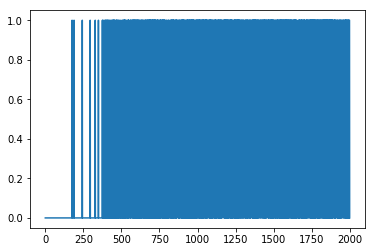

In [6]:
plt.plot(rList)

## 에피소드별 단계 수를 담은 리스트를 출력

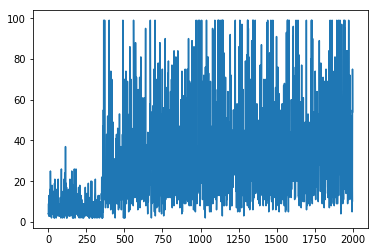

In [7]:
plt.plot(jList)